<a href="https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic5/5.2_llm_as_a_judge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy
Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon.

# 5.2. LLM-as-a-judge

**Author: Alex Umnov**

Links:

- [LinkedIn](www.linkedin.com/in/alex-umnov)
- Discord Profile: alexumnov, best to tag at #nebius-academy

As LLMs develop and become even better at virtually any task, it becomes increasingly popular to use them as "judges" to replace human annotators in various evaluation scenarios. You might rely on LLM-as-a-Judge in situations such as these:

- If you are unable to collect enough high-quality annotated data to evaluate a discriminative task (for example, classification)
- If you need to evaluate artifacts of a creative tasks, such as summarization, where there is no fixed ground truth
- If you need to score something inevitably subjective, such as how much engaging a conversation is.

# Imports, clients, etc.

In [ ]:
!pip install openai -qU
!pip install -qU datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requi

In [ ]:
from google.colab import userdata
from openai import OpenAI
import os

os.environ['NEBIUS_API_KEY'] = userdata.get("nebius_api_key")

nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

llama_model = "meta-llama/Llama-3.3-70B-Instruct"

def prettify_string(text, max_line_length=80):
    """Prints a string with line breaks at spaces to prevent horizontal scrolling.

    Args:
        text: The string to print.
        max_line_length: The maximum length of each line.
    """

    output_lines = []
    lines = text.split("\n")
    for line in lines:
        current_line = ""
        words = line.split()
        for word in words:
            if len(current_line) + len(word) + 1 <= max_line_length:
                current_line += word + " "
            else:
                output_lines.append(current_line.strip())
                current_line = word + " "
        output_lines.append(current_line.strip())  # Append the last line
    return "\n".join(output_lines)

def answer_with_llm(prompt: str,
                    system_prompt="You are a helpful assistant",
                    max_tokens=512,
                    client=nebius_client,
                    model=llama_model,
                    prettify=True,
                    temperature=None) -> str:

    messages = []

    if system_prompt:
        messages.append(
            {
                "role": "system",
                "content": system_prompt
            }
        )

    messages.append(
        {
            "role": "user",
            "content": prompt
        }
    )

    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_tokens,
        temperature=temperature
    )

    if prettify:
        return prettify_string(completion.choices[0].message.content)
    else:
        return completion.choices[0].message.content

In the following sections we'll explore using LLM-as-a-Judge in more details.

# LLM-as-a-Judge

One of the first comprehensive studies on the matter was [Judging LLM-as-a-Judge
with MT-Bench and Chatbot Arena by Zheng et. al](https://arxiv.org/pdf/2306.05685), where the authors explored using LLMs as a preference judge for dialogs.

Let's try to implement a judge, which, given assistant's answers labeled A and B, decides which is better based on the question user have asked and some internal criteria.

The judge will output:
- **"[[A]]"** if the first passed answer is better;
- **"[[B]]"** if the second;
- **"[[C]]"** if they are equality good/bad.

In [ ]:
from enum import StrEnum

system_prompt = """
Please act as an impartial judge and evaluate the quality of the responses provided by two
AI assistants to the user question displayed below. You should choose the assistant that
follows the user’s instructions and answers the user’s question better. Your evaluation
should consider factors such as the helpfulness, relevance, accuracy, depth, creativity,
and level of detail of their responses. Begin your evaluation by comparing the two
responses and provide a short explanation. Avoid any position biases and ensure that the
order in which the responses were presented does not influence your decision. Do not allow
the length of the responses to influence your evaluation. Do not favor certain names of
the assistants. Be as objective as possible. After providing your explanation, output your
final verdict by strictly following this format: "[[A]]" if assistant A is better, "[[B]]"
if assistant B is better, and "[[C]]" for a tie.
"""

user_prompt = """
{question}
[The Start of Assistant A’s Answer]
{answer_a}
[The End of Assistant A’s Answer]
[The Start of Assistant B’s Answer]
{answer_b}
[The End of Assistant B’s Answer]
"""

def judge_answers_pairwise(
    question: str,
    answer_a: str,
    answer_b: str,
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    client=nebius_client,
    model=llama_model,
):
    prompt = user_prompt.format(
        question=question,
        answer_a=answer_a,
        answer_b=answer_b
    )
    return answer_with_llm(prompt, system_prompt=system_prompt, client=client, model=model, prettify=True)


In [ ]:
print(judge_answers_pairwise(
    question="What is the most reliable ways of slaying a vampire and why?",
    answer_a="Just use your sharpest sword. No one can whistand a strong blow with a mighty sword",
    answer_b="Simple attacks don't work on vampires. You best bet is to use silver, garlic or sunlight as those stop them from regenerating."
))

Upon comparing the two responses, it's clear that Assistant B provides a more
detailed and accurate answer to the user's question. Assistant A's response is
overly simplistic and doesn't take into account the common mythological
weaknesses associated with vampires. In contrast, Assistant B mentions specific
methods (silver, garlic, and sunlight) that are traditionally believed to be
effective against vampires, and also explains why they are effective
(preventing regeneration). This shows a better understanding of the vampire
mythology and provides more helpful information to the user.

[[B]]


In [ ]:
print(judge_answers_pairwise(
    question="I'm going to open a potion shop, which supply and equipment should I buy?",
    answer_a="The most essential things would be: a brewing station or a cauldron, ingredients like herbs and minerals and a steady supply of water. You might also need a book with potion recipies.",
    answer_b="You'll need a brewing station for sure. Also buy some ingredients. A brewing station is very important.",
))

Upon comparing the two responses, it's clear that Assistant A provides a more
comprehensive and detailed answer to the user's question. Assistant A lists
specific ingredients such as herbs and minerals, mentions the need for a steady
supply of water, and suggests having a book with potion recipes. These
additional details demonstrate a better understanding of the requirements for a
potion shop and provide more helpful guidance for the user.

In contrast, Assistant B's response is brief and lacks specificity. While it
confirms the importance of a brewing station, it doesn't offer much additional
information or insights, making it less helpful for someone looking to set up a
potion shop.

Given the differences in the quality and usefulness of the responses, my
evaluation concludes that Assistant A provides a better answer.

[[A]]


In [ ]:
print(judge_answers_pairwise(
    question="What are the main characteristics of dragons?",
    answer_a="Dragons have wings, scales and breathe fire.",
    answer_b="Dragons breathe fire, have wings and scales.",
))

After comparing the two responses, it's clear that both assistants provide
similar information about the main characteristics of dragons, including the
ability to breathe fire, having wings, and having scales. The order of the
characteristics listed differs between the two responses, but the content is
essentially the same. Neither response provides additional depth, creativity,
or detail beyond the basic characteristics mentioned. Given that both responses
are equivalent in terms of the information they convey and neither offers a
more comprehensive or insightful answer, the evaluation concludes that they are
of equal quality.

[[C]]


## Style vs knowledge

It's important to distinguish between

- situations where we want an LLM judge to score an answer's **style** and
- situations where we want it to score **factuality**

In the first case, we can usually rely on LLM's intrinsic sense of beauty (assisted by a clever prompt). In the second case, the judge will fail if it encounters something outside its knowledge cutoff, or just anything outside of its expertese.

In [ ]:
print(judge_answers_pairwise(
    question="What is my favorite fruit?",
    answer_a="Apples",
    answer_b="Bananas",
))

To evaluate the quality of the responses provided by the two AI assistants, we
must consider the factors of helpfulness, relevance, accuracy, depth,
creativity, and level of detail in relation to the user's question, "What is my
favorite fruit?"

Both Assistant A and Assistant B provide a response by naming a fruit (Apples
and Bananas, respectively). However, neither response directly addresses the
user's question about their personal preference, as the information about the
user's favorite fruit is not provided in the query. Both assistants make
assumptions without basis.

Given the lack of information about the user's preferences, both responses are
speculative and do not truly answer the question as it pertains to the user's
personal taste. Neither response demonstrates a deeper understanding or
provides additional context that could make one more accurate or helpful than
the other in this specific scenario.

Since both assistants fail to provide a relevant or accurate answer due to

In [ ]:
print(judge_answers_pairwise(
    question="Who was the winner of 2025 eurovision?",
    answer_a="JJ",
    answer_b="Nemo",
))

To evaluate the responses provided by the two AI assistants, we must consider
the helpfulness, relevance, accuracy, depth, creativity, and level of detail in
their answers. The user's question is about the winner of the 2025 Eurovision
contest.

Both Assistant A and Assistant B provided very brief responses, "JJ" and
"Nemo," respectively. Neither response directly addresses the question about
the winner of the 2025 Eurovision contest in a meaningful or informative way.
However, the critical issue here is that the 2025 Eurovision contest has not
occurred yet, as my knowledge cutoff is before the event. Thus, neither
assistant could have provided an accurate answer based on real-time or future
events.

Given the nature of the responses and the fact that the event in question has
not happened, it's challenging to declare a clear winner based on the provided
answers. Both responses lack relevance, accuracy, and detail regarding the
question asked. Since neither assistant provided a useful 

It doesn't matter how well we describe the judgement criteria, if the LLM has no knowledge of a certain event, it cannot give us the right judgement. In the worst case, the model will hallucinate.

# Search Augmented Factual Evaluator

To remedy this, we can augment the judge with a search tool, so that the model could have access to the necessary information. Additionally it's a good idea to break the answer into separate claims, find relevant information, and then answer whether the answer is factually correct.

This approach was described in this paper: [Long-form factuality in large language models Wei et. al](https://arxiv.org/pdf/2403.18802)

In [ ]:
def separate_claims(answer):
    answer = answer_with_llm(
        system_prompt="Given a statement separate it into separate independant claims and write only those claims divided by ';'." \
            "Each claim should have it's own independant context without referencing other claims with pronouns without naming the object.",
        prompt=f"Statement: {answer}",
        client=nebius_client,
        model=llama_model,
    )
    return [claim.strip() for claim in answer.split(";")]


separate_claims("The sun is very hot, it is a star, it is at the center of solar system.")

['The sun is very hot',
 'The sun is a star',
 'The sun is at the center of the solar\nsystem.']

We'll use [tavily](https://www.tavily.com/) as the search engine.

**Before running the cell, make sure you have you tavily API key in the `tavily_api_key` environmental variable**. For that, either add it to colab secrets or write the key into the environmental variable `TAVILY_API_KEY` manually.

In [ ]:
!pip install -q tavily-python


In [ ]:
from tavily import TavilyClient
from google.colab import userdata

"""
# Environmental variable way:
import os
tavily_api_key = # your tavily api key here
os.environ["TAVILY_API_KEY"] = tavily_api_key
tavily_client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))
"""

# Colab secrets way:
tavily_client = TavilyClient(api_key=userdata.get("tavily_api_key"))

def get_search_results(query: str, search_client=tavily_client,
                       search_depth="advanced", max_results=5) -> str:
    """
    Perform a web search using Tavily API and format the results.

    Args:
        query: Search query string
        search_depth: 'basic' for faster but less comprehensive results,
                     'advanced' for more thorough but more expensive results

    Returns:
        Formatted string containing search results and their sources
    """
    search_results = search_client.search(
        query=query,
        search_depth=search_depth,
        max_results=max_results  # Adjust as needed
    )

    formatted_results = []
    for result in search_results['results']:
        content = result.get('content', '').strip()
        url = result.get('url', '')
        if content:
            formatted_results.append(f"Content: {content}\nSource: {url}\n")

    return "\n".join(formatted_results)

def search_claim_context(claim, verbose=False):
    llm_answer = answer_with_llm(
        system_prompt="Based on the following claim formulate a search query that will help you obtain relevant context to validate claim's factuality."\
            "Only output one variant of search query. Output after 'Search query:'",
        prompt=f"Claim: {claim}",
        client=nebius_client,
        model=llama_model,
    )
    if verbose:
        print(llm_answer)
    search_query = llm_answer.split("Search query:")[-1].strip()
    return  get_search_results(search_query)

In [ ]:
search_claim_context("Barack Obama is the current president of the United States.", verbose=True)

Search query: current president of the United States


'Content: The **President of the United States** (POTUS) is the head of the United States government. [Article II of the U.S. Constitution](/Article_II,_United_States_Constitution "Article II, United States Constitution") laid out the requirements and roles of the president.[[1]](#cite_note-1) The current President of the United States is [Donald Trump](https://ballotpedia.org/Donald_Trump) (R). Trump assumed office in 2025.\n\n## Election requirements [...] | [v](/Template:Executive_branch "Template:Executive branch")\xa0•\xa0[e](https://ballotpedia.org/wiki/index.php?title=Template:Executive_branch&action=edit) [U.S. Executive Branch](/Executive_Branch "Executive Branch") | | |\n| --- | --- | --- |\n|  |\n| Elected offices | President [Donald Trump](/Donald_Trump "Donald Trump") • Vice President [J.D. Vance](/J.D._Vance "J.D. Vance")   --- | [Executive-Branch-Logo.png](/Executive_Branch "Executive Branch") |\n|  | [...] [Gerald Ford](/Gerald_Ford "Gerald Ford")\xa0• [Jimmy Carter](/J

Now we have everything we need to build a simple search augmented factual verifier.

In [ ]:

verify_system_prompt = """
Given a statement and supporting evidence acquired from web search
verify whether the statement is fully factually correct or not.
If the statement is correct output [[CORRECT]] otheriwise [[INCORRECT]]
"""

verify_user_prompt = """
Statement: {statement}
Evidence: {evidence}
"""

def verify_statement(statement, verbose=False):
    claims = separate_claims(statement)
    if verbose:
        print(claims)
    final_context = ""
    for claim in claims:
        search_results = search_claim_context(claim, verbose=verbose)
        final_context += search_results + "\n"

    prompt = verify_user_prompt.format(
        statement=statement,
        evidence=final_context
    )

    return answer_with_llm(
        system_prompt=verify_system_prompt,
        prompt=prompt,
        client=nebius_client,
        model=llama_model,
    )

In [ ]:
verify_statement("Barack Obama is the current president of the United States.", verbose=True)

['Barack Obama is the president of the United States', 'The United States has a\ncurrent president.']
Search query: Barack Obama current presidential status
Search query: current president of the United States


'[[INCORRECT]]\n\nThe statement "Barack Obama is the current president of the United States" is\nnot factually correct. According to the provided evidence, Barack Obama was the\n44th President of the United States, serving from 2009 to 2017. The current\npresident of the United States is Donald Trump, who was sworn into office on\nJanuary 20, 2025.'

As we can see here, it can be a bit excessive. This can be addressed by perfecting the prompts. However it's better safe than sorry.

In [ ]:
verify_statement("The winner of Eurovision 2025 is JJ with a song Wasted Love who was representing Austria", verbose=True)

['JJ is the winner of Eurovision 2025', 'JJ performed the song Wasted Love', 'JJ\nrepresented Austria in Eurovision 2025.']
Search query: "Eurovision 2025 winner"
Search query: JJ Wasted Love song verification
Search query: Eurovision 2025 Austria representative


'[[CORRECT]]\n\nThe statement is fully factually correct. The evidence from various sources,\nincluding news articles and official Eurovision websites, confirms that JJ,\nrepresenting Austria, won the Eurovision Song Contest 2025 with the song\n"Wasted Love".'

# SummEval dataset

Let's try LLM-as-a-judge in different flavours applied to more realistic data.

We'll use [SummEval dataset](https://github.com/Yale-LILY/SummEval) as an example.

In [ ]:
!pip install -qU datasets

In [ ]:
from datasets import load_dataset

# if you are in collab, this will require HF_TOKEN secret.
# alternatively you can login to huggingface using for example `!huggingface-cli login`

ds = load_dataset("mteb/summeval")

README.md:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

data/test-00000-of-00001-35901af5f664939(…):   0%|          | 0.00/423k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
df = ds['test'].to_pandas()
df.head()

,machine_summaries,human_summaries,relevance,coherence,fluency,consistency,text,id
0,"[donald sterling , nba team last year . sterli...",[V. Stiviano must pay back $2.6 million in gif...,"[1.6666666666666667, 1.6666666666666667, 2.333...","[1.3333333333333333, 3.0, 1.0, 2.6666666666666...","[1.0, 4.666666666666667, 4.333333333333333, 4....","[1.0, 2.3333333333333335, 4.666666666666667, 5...",(CNN)Donald Sterling's racist remarks cost him...,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9
1,[north pacific gray whale has earned a spot in...,"[The whale, Varvara, swam a round trip from Ru...","[2.3333333333333335, 4.666666666666667, 3.6666...","[1.3333333333333333, 4.666666666666667, 3.6666...","[1.0, 5.0, 4.666666666666667, 3.66666666666666...","[1.3333333333333333, 5.0, 5.0, 4.3333333333333...",(CNN)A North Pacific gray whale has earned a s...,cnn-test-4761dc6d8bdf56b9ada97104113dd1bcf4aed3f1
2,[russian fighter jet intercepted a u.s. reconn...,[The incident occurred on April 7 north of Pol...,"[4.0, 4.0, 4.0, 3.3333333333333335, 3.33333333...","[3.3333333333333335, 4.333333333333333, 1.6666...","[3.6666666666666665, 4.333333333333333, 5.0, 4...","[5.0, 5.0, 4.666666666666667, 5.0, 5.0, 5.0, 5...",(CNN)After a Russian fighter jet intercepted a...,cnn-test-5139ccfabee55ddb83e7937f5802c0a67aee8975
3,[michael barnett captured the fire on intersta...,[Country band Lady Antebellum's bus caught fir...,"[2.0, 3.0, 2.6666666666666665, 3.3333333333333...","[2.0, 3.0, 2.6666666666666665, 3.3333333333333...","[2.6666666666666665, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[2.3333333333333335, 5.0, 5.0, 5.0, 5.0, 5.0, ...",(CNN)Lady Antebellum singer Hillary Scott's to...,cnn-test-88c2481234e763c9bbc68d0ab1be1d2375c1349a
4,[deep reddish color caught seattle native tim ...,[Smoke from massive fires in Siberia created f...,"[1.6666666666666667, 3.6666666666666665, 3.333...","[1.6666666666666667, 3.6666666666666665, 1.666...","[5.0, 5.0, 5.0, 5.0, 4.666666666666667, 5.0, 5...","[2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",(CNN)A fiery sunset greeted people in Washingt...,cnn-test-a02e362c5b8f049848ce718b37b96117485461cf


In [ ]:
df[['text', 'machine_summaries', 'relevance']].iloc[0].to_dict()

{'text': '(CNN)Donald Sterling\'s racist remarks cost him an NBA team last year. But now it\'s his former female companion who has lost big. A Los Angeles judge has ordered V. Stiviano to pay back more than $2.6 million in gifts after Sterling\'s wife sued her. In the lawsuit, Rochelle "Shelly" Sterling accused Stiviano of targeting extremely wealthy older men. She claimed Donald Sterling used the couple\'s money to buy Stiviano a Ferrari, two Bentleys and a Range Rover, and that he helped her get a $1.8 million duplex. Who is V. Stiviano? Stiviano countered that there was nothing wrong with Donald Sterling giving her gifts and that she never took advantage of the former Los Angeles Clippers owner, who made much of his fortune in real estate. Shelly Sterling was thrilled with the court decision Tuesday, her lawyer told CNN affiliate KABC. "This is a victory for the Sterling family in recovering the $2,630,000 that Donald lavished on a conniving mistress," attorney Pierce O\'Donnell sai

The dataset's entries consist of:

- an original text,
- its 16 machine summaries
- 16 corresponding entries for relevance, coherence, fluency and consistency.
- "golden" summaries

We'll try to use different techniques to predict the summarisation quality values.

We'll take a small sample of data to test our approaches.

In [ ]:
split_record = 50
valid_df = df.iloc[:split_record]
test_df = df.iloc[split_record:]
print(len(valid_df), len(test_df))

50 50


Let's flatten those dfs so that it's a bit easier to work with.

In [ ]:
valid_df_flat = valid_df.explode(
    ['machine_summaries', 'relevance', 'consistency', 'fluency', 'coherence']
)
valid_df_flat = valid_df_flat.reset_index(drop=True)
valid_df_flat

,machine_summaries,human_summaries,relevance,coherence,fluency,consistency,text,id
0,"donald sterling , nba team last year . sterlin...",[V. Stiviano must pay back $2.6 million in gif...,1.666667,1.333333,1.0,1.0,(CNN)Donald Sterling's racist remarks cost him...,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9
1,donald sterling accused stiviano of targeting ...,[V. Stiviano must pay back $2.6 million in gif...,1.666667,3.0,4.666667,2.333333,(CNN)Donald Sterling's racist remarks cost him...,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9
2,a los angeles judge has ordered v. stiviano to...,[V. Stiviano must pay back $2.6 million in gif...,2.333333,1.0,4.333333,4.666667,(CNN)Donald Sterling's racist remarks cost him...,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9
3,donald sterling 's wife sued stiviano of targe...,[V. Stiviano must pay back $2.6 million in gif...,3.333333,2.666667,4.333333,5.0,(CNN)Donald Sterling's racist remarks cost him...,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9
4,donald sterling 's racist remarks cost him an ...,[V. Stiviano must pay back $2.6 million in gif...,3.0,4.666667,5.0,5.0,(CNN)Donald Sterling's racist remarks cost him...,cnn-test-404f859482d47c127868964a9a39d1a7645dd2e9
...,...,...,...,...,...,...,...,...
795,"manchester city players will lose # 500,000-a-...",[City's players are on incentivised contracts ...,3.0,2.333333,5.0,5.0,"Manchester City players will lose £500,000-a-m...",dm-test-5be0a9584b051175d9f4842a143b76385335d96a
796,Manchester City are on incentivised contracts ...,[City's players are on incentivised contracts ...,5.0,5.0,5.0,5.0,"Manchester City players will lose £500,000-a-m...",dm-test-5be0a9584b051175d9f4842a143b76385335d96a
797,"manchester city players will lose £500,000-a-m...",[City's players are on incentivised contracts ...,4.0,1.666667,5.0,5.0,"Manchester City players will lose £500,000-a-m...",dm-test-5be0a9584b051175d9f4842a143b76385335d96a
798,"manchester city players will lose # 500,000-a-...",[City's players are on incentivised contracts ...,3.333333,3.333333,5.0,5.0,"Manchester City players will lose £500,000-a-m...",dm-test-5be0a9584b051175d9f4842a143b76385335d96a


In [ ]:
test_df_flat = test_df.explode(
    ['machine_summaries', 'relevance', 'consistency', 'fluency', 'coherence']
)
test_df_flat = test_df_flat.reset_index(drop=True)
test_df_flat

,machine_summaries,human_summaries,relevance,coherence,fluency,consistency,text,id
0,serge gnabry says he is feeling ` better and b...,[Serge Gnabry impressed for Arsenal last seaso...,2.666667,1.666667,5.0,1.666667,Serge Gnabry says he is feeling 'better and be...,dm-test-632cfdb03aacd90a34a470f6a70b47eee62ec5f0
1,serge gnabry played 90 minutes for arsenal und...,[Serge Gnabry impressed for Arsenal last seaso...,3.0,4.666667,5.0,5.0,Serge Gnabry says he is feeling 'better and be...,dm-test-632cfdb03aacd90a34a470f6a70b47eee62ec5f0
2,serge gnabry played 90 minutes for arsenal und...,[Serge Gnabry impressed for Arsenal last seaso...,4.0,3.333333,5.0,5.0,Serge Gnabry says he is feeling 'better and be...,dm-test-632cfdb03aacd90a34a470f6a70b47eee62ec5f0
3,serge gnabry played 90 minutes for arsenal und...,[Serge Gnabry impressed for Arsenal last seaso...,4.666667,2.666667,5.0,5.0,Serge Gnabry says he is feeling 'better and be...,dm-test-632cfdb03aacd90a34a470f6a70b47eee62ec5f0
4,serge gnabry says he is feeling ` better and b...,[Serge Gnabry impressed for Arsenal last seaso...,3.666667,3.333333,5.0,5.0,Serge Gnabry says he is feeling 'better and be...,dm-test-632cfdb03aacd90a34a470f6a70b47eee62ec5f0
...,...,...,...,...,...,...,...,...
795,a 23-year-old mother-of-two is at risk of bein...,"[Gemma, 23, has left her children to be raised...",5.0,5.0,5.0,5.0,A 23-year-old mother-of-two is at risk of bein...,dm-test-fadabe346fe95d33eee71299e6596754768f5246
796,"Gemma , 23 , has two children under five by tw...","[Gemma, 23, has left her children to be raised...",4.666667,3.333333,5.0,5.0,A 23-year-old mother-of-two is at risk of bein...,dm-test-fadabe346fe95d33eee71299e6596754768f5246
797,"gemma , named only as gemma , has two children...","[Gemma, 23, has left her children to be raised...",3.666667,4.0,4.0,5.0,A 23-year-old mother-of-two is at risk of bein...,dm-test-fadabe346fe95d33eee71299e6596754768f5246
798,"the woman , named only as gemma , has two chil...","[Gemma, 23, has left her children to be raised...",5.0,5.0,4.333333,5.0,A 23-year-old mother-of-two is at risk of bein...,dm-test-fadabe346fe95d33eee71299e6596754768f5246


## Position bias

**Position bias** refers to a well-known tendency of the LLMs-as-judges to favour the first candidate (or otherwise give different scores depending on the order of candidates).

Let's pick one "good" and one "bad" summary for each text and ask LLM to choose a better one in "first good, then bad" and "first bad, then good" situations.

In [ ]:
import pandas as pd
import random

test_df_pairwise = []

for text_id, group in test_df_flat.groupby('text'):
    random_summaries = group.sample(n=2)
    summary_a = random_summaries.iloc[0].to_dict()
    summary_b = random_summaries.iloc[1].to_dict()

    if summary_a['relevance'] > summary_b['relevance']:
        more_relevant = 'a'
    elif summary_a['relevance'] < summary_b['relevance']:
        more_relevant = 'b'
    else:
        more_relevant = 'c'

    record = {
        'original_text': group['text'].iloc[0],
        'summary_a': summary_a['machine_summaries'],
        'summary_b': summary_b['machine_summaries'],
        'relevance_a': summary_a['relevance'],
        'relevance_b': summary_b['relevance'],
        'more_relevant': more_relevant
    }

    test_df_pairwise.append(record)

test_df_pairwise = pd.DataFrame(test_df_pairwise)

test_df_pairwise

,original_text,summary_a,summary_b,relevance_a,relevance_b,more_relevant
0,A 23-year-old mother-of-two is at risk of bein...,"the woman , named only as gemma , has two chil...","woman, named only as gemma, has two children u...",4.333333,5.000000,b
1,A dress worn by Vivien Leigh when she played S...,heritage auctions offered the gray jacket and ...,dress worn by vivien leigh when she played sca...,3.000000,4.666667,b
2,A lonely man has taken his search for love - o...,"'rich' , who lives in humpty doo , northern te...",lonely man has taken his search for love - or ...,4.000000,4.000000,c
3,A predatory convicted paedophile with an obses...,"stephen munden , 54 , described as having a ` ...","stephen munden , 54 , described as having a ` ...",4.666667,4.333333,a
4,A teacher has been banned from the classroom a...,ian guffick asked pupils to make changes to th...,ian guffick asked pupils to make changes to th...,4.000000,4.000000,c
5,A teenager from Illinois is tackling her disab...,"dayna dobias , 19 , from downers grove was bor...","dayna dobias, 19, from downers grove was born ...",4.333333,4.333333,c
6,A timewarp home which has remained unchanged s...,the timewarp home has remained unchanged since...,"the collector 's paradise in horfield , bristo...",5.000000,3.666667,a
7,A video of a menacing crocodile swimming throu...,new zealander tim weston was on holiday in pue...,the clip shows a large croc calmly moving thro...,4.000000,4.333333,b
8,A woman who suffered seven miscarriages has sp...,"Dawn , who has had seven miscarriages , was ap...","bereaved mother , named dawn , was appearing o...",4.333333,2.333333,a
9,A young accountant fell down a 70ft cliff to h...,"jacob phillips, 23, fell down the cliff at the...","graduate jacob phillips , 23 , plunged down th...",4.000000,3.333333,a


In [ ]:
from enum import StrEnum

system_prompt = """
You are presented with original text and two summaries generated from it.
You should evaluate which one is more relevant compare to another one.
If summary_a is more relevant output [[a]], if summary_b is more relevant output
[[b]] else output [[c]].
Output in the following format:
- First all the reasoning you have
- Finally answer after "Answer: "
"""

user_prompt = """
Original text:
{text}
Summary A:
{summary_a}
Summary B:
{summary_b}
More relevant summary:
"""

def pairwise_summary_relevance_judge(
    text: str,
    summary_a: str,
    summary_b: str,
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    client=nebius_client,
    model=llama_model,
):
    prompt = user_prompt.format(
        text=text,
        summary_a=summary_a,
        summary_b=summary_b
    )
    return answer_with_llm(
        prompt,
        system_prompt=system_prompt,
        client=client,
        model=model,
        prettify=False
    ).split('Answer: ')[-1]


And now we'll test this judge in three different scenarios:

1. The most relevant is always summary a
2. The most relevant is always summary b
3. The most relevant is a uniformly random one a or b

In [ ]:
import random
from tqdm.auto import tqdm

always_a_predictions = []
always_b_predictions = []
random_predictions = []
random_labels = []

for record in tqdm(test_df_pairwise.to_dict(orient='records')):
    more_relevant = record['more_relevant']
    more_relevant_summary = record['summary_a'] if more_relevant == 'a' else record['summary_b']
    less_relevant_summary = record['summary_b'] if more_relevant == 'a' else record['summary_a']

    always_a_prediction = pairwise_summary_relevance_judge(
        text=record['original_text'],
        summary_a=more_relevant_summary,
        summary_b=less_relevant_summary,
    )
    always_b_prediction = pairwise_summary_relevance_judge(
        text=record['original_text'],
        summary_a=less_relevant_summary,
        summary_b=more_relevant_summary,
    )

    if random.random() > 0.5:
        random_prediction = pairwise_summary_relevance_judge(
            text=record['original_text'],
            summary_a=more_relevant_summary,
            summary_b=less_relevant_summary,
        )
        random_labels.append('[[a]]')
    else:
        random_prediction = pairwise_summary_relevance_judge(
            text=record['original_text'],
            summary_a=less_relevant_summary,
            summary_b=more_relevant_summary,
        )
        random_labels.append('[[b]]')

    always_a_predictions.append(always_a_prediction)
    always_b_predictions.append(always_b_prediction)
    random_predictions.append(random_prediction)

always_a_accuracy = sum(int('[[a]]' == prediction) for prediction in always_a_predictions) / len(always_a_predictions)
always_b_accuracy = sum(int('[[b]]' == prediction) for prediction in always_b_predictions) / len(always_b_predictions)
random_accuracy = sum(int(label == prediction) for label, prediction in zip(random_labels, random_predictions)) / len(random_labels)

print(f"Always a accuracy: {always_a_accuracy}")
print(f"Always b accuracy: {always_b_accuracy}")
print(f"Random order accuracy: {random_accuracy}")

  0%|          | 0/50 [00:00<?, ?it/s]

Always a accuracy: 0.68
Always b accuracy: 0.56
Random order accuracy: 0.66


There's a significatnt fluctuation present. It can also change between runs.


Position bias is definitely something that should be taken into account when using llm as a judge. For example when benchmarking it, it's worth making sure that the distribution of positions for the answer is uniform or close to the actual data which it'll be used on.

## Concrete criteria

In case of LLM-as-a-judge, the quality of your predictions directly benefits from how well your evaluation criteria were formulated.

Let's consider several setups with increasing criteria complexity and see how much this improves predictions.

We'll use structured outputs for easier extraction of particular evaluation scores - relevance, coherence, fluency, and consistency.

In [ ]:
from pydantic import BaseModel

class SummarisationEvaluation(BaseModel):
    relevance: int
    coherence: int
    fluency: int
    consistency: int


class SummarisationJudge:
    def __init__(self, client, model, system_prompt, user_prompt, guided_json):
        self.client = client
        self.model = model
        self.system_prompt = system_prompt
        self.user_prompt = user_prompt
        self.guided_json = guided_json

    def evaluate(self, original_text: str, summary: str):
        completion = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": self.system_prompt},
                {
                    "role": "user",
                    "content": self.user_prompt.format(
                        original_text=original_text,
                        summary=summary
                    )
                }
            ],
            extra_body={
                "guided_json": SummarisationEvaluation.model_json_schema()
            }
        )

        return SummarisationEvaluation.model_validate_json(completion.choices[0].message.content)


Let's start with the simplest prompt we can do.

We'll evaluate MSE for every score direction.

In [ ]:
system_prompt = """
You are presented with an original text and a summary generated from it.
Evaluate on the scale from 1 to 5
- relevance
- coherence
- fluency
- consistency
"""

user_prompt = """
Original text:
{original_text}
Summary:
{summary}
"""

naive_judge = SummarisationJudge(
    client=nebius_client,
    model=llama_model,
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    guided_json=SummarisationEvaluation.model_json_schema()
)

In [ ]:
from tqdm.auto import tqdm

sample_size = 50
relevance_squared_errors = []
coherence_squared_errors = []
fluency_squared_errors = []
consistency_squared_errors = []

for record in tqdm(test_df_flat[:sample_size].to_dict(orient='records')):
    evaluation = naive_judge.evaluate(
        original_text=record['text'],
        summary=record['machine_summaries']
    )
    relevance_squared_errors.append((evaluation.relevance - record['relevance']) ** 2)
    coherence_squared_errors.append((evaluation.coherence - record['coherence']) ** 2)
    fluency_squared_errors.append((evaluation.fluency - record['fluency']) ** 2)
    consistency_squared_errors.append((evaluation.consistency - record['consistency']) ** 2)

print(f"MSE for relevance: {sum(relevance_squared_errors) / len(relevance_squared_errors)}")
print(f"MSE for coherence: {sum(coherence_squared_errors) / len(coherence_squared_errors)}")
print(f"MSE for fluency: {sum(fluency_squared_errors) / len(fluency_squared_errors)}")
print(f"MSE for consistency: {sum(consistency_squared_errors) / len(consistency_squared_errors)}")

  0%|          | 0/50 [00:00<?, ?it/s]

MSE for relevance: 0.6733333333333333
MSE for coherence: 0.717777777777778
MSE for fluency: 2.4599999999999995
MSE for consistency: 0.7022222222222223


It's not bad, but let's try giving the judge instructions similar to the instructions which human annotators got in the original [paper](https://arxiv.org/pdf/2007.12626).

In [ ]:
system_prompt = """
Instructions
In this task you will evaluate the quality of summaries written for a news article.
To correctly solve this task, follow these steps:
1. Carefully read the news article, be aware of the information it contains.
2. Read the proposed summary
3. Rate each summary on a scale from 1 (worst) to 5 (best) by its relevance, consistency, fluency, and coherence.
Definitions
Relevance:
The rating measures how well the summary captures the key points of the article.
Consider whether all and only the important aspects are contained in the summary.
Consistency:
The rating measures whether the facts in the summary are consistent with the facts in the original article.
Consider whether the summary does reproduce all facts accurately and does not make up untrue information.
Fluency
This rating measures the quality of individual sentences, are they well-written and grammatically correct.
Consider the quality of individual sentences.
Coherence:
The rating measures the quality of all sentences collectively, to the fit together and sound naturally.
Consider the quality of the summary as a whole.
"""

user_prompt = """
Original text:
{original_text}
Summary:
{summary}
"""

human_instruction_judge = SummarisationJudge(
    client=nebius_client,
    model=llama_model,
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    guided_json=SummarisationEvaluation.model_json_schema()
)

sample_size = 50
relevance_squared_errors = []
coherence_squared_errors = []
fluency_squared_errors = []
consistency_squared_errors = []

for record in tqdm(test_df_flat[:sample_size].to_dict(orient='records')):
    evaluation = human_instruction_judge.evaluate(
        original_text=record['text'],
        summary=record['machine_summaries']
    )
    relevance_squared_errors.append((evaluation.relevance - record['relevance']) ** 2)
    coherence_squared_errors.append((evaluation.coherence - record['coherence']) ** 2)
    fluency_squared_errors.append((evaluation.fluency - record['fluency']) ** 2)
    consistency_squared_errors.append((evaluation.consistency - record['consistency']) ** 2)

print(f"MSE for relevance: {sum(relevance_squared_errors) / len(relevance_squared_errors)}")
print(f"MSE for coherence: {sum(coherence_squared_errors) / len(coherence_squared_errors)}")
print(f"MSE for fluency: {sum(fluency_squared_errors) / len(fluency_squared_errors)}")
print(f"MSE for consistency: {sum(consistency_squared_errors) / len(consistency_squared_errors)}")

  0%|          | 0/50 [00:00<?, ?it/s]

MSE for relevance: 0.3133333333333333
MSE for coherence: 0.5844444444444443
MSE for fluency: 3.853333333333333
MSE for consistency: 0.27555555555555555


It can vary across runs, but in our case everything improved except for the fluency. It could be that the instruction is unclear for AI, but clear for Humans. Or the annotators made some mistakes.

Finally, as we know already, few shot improves everything, so let's add some shots.

In [ ]:
few_shots = ""
for record in valid_df_flat.sample(10).to_dict(orient='records'):
    few_shots += f"""\n
Original text:
{record['text']}
Summary:
{record['machine_summaries']}
- relevance: {record['relevance']}
- coherence: {record['coherence']}
- fluency: {record['fluency']}
- consistency: {record['consistency']}
\n"""

print(few_shots)



Original text:
(CNN)ISIS on Wednesday released more than 200 Yazidis, a minority group whose members were killed, captured and displaced when the Islamist terror organization overtook their towns in northern Iraq last summer, officials said. Most of those released were women and children; the rest were ill or elderly, said Rassol Omar, a commander in the Peshmerga force that defends  northern Iraq's semi-autonomous Kurdish region. Omar didn't say what led to the release, other than asserting that Arab tribal leaders helped to coordinate it. The freed Yazidis were received by Peshmerga, who sent them to the Kurdish regional capital, Irbil, said Nuri Osman, an official with Iraq's Kurdistan Regional Government. It wasn't immediately clear what motivated Wednesday's release, Osman said. Osman said 217 Yazidis were released. Omar, the Peshmerga commander, had a higher count: 228. ISIS previously released scores of other Yazidis -- largely children and the elderly -- since attacking the g

In [ ]:
system_prompt = f"""
Instructions
In this task you will evaluate the quality of summaries written for a news article.
To correctly solve this task, follow these steps:
1. Carefully read the news article, be aware of the information it contains.
2. Read the proposed summary
3. Rate each summary on a scale from 1 (worst) to 5 (best) by its relevance, consistency, fluency, and coherence.
Definitions
Relevance:
The rating measures how well the summary captures the key points of the article.
Consider whether all and only the important aspects are contained in the summary.
Consistency:
The rating measures whether the facts in the summary are consistent with the facts in the original article.
Consider whether the summary does reproduce all facts accurately and does not make up untrue information.
Fluency
This rating measures the quality of individual sentences, are they well-written and grammatically correct.
Consider the quality of individual sentences.
Coherence:
The rating measures the quality of all sentences collectively, to the fit together and sound naturally.
Consider the quality of the summary as a whole.
Here are some examples

{few_shots}
"""

user_prompt = """
Original text:
{original_text}
Summary:
{summary}
"""

human_instruction__few_shots_judge = SummarisationJudge(
    client=nebius_client,
    model=llama_model,
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    guided_json=SummarisationEvaluation.model_json_schema()
)

sample_size = 50
relevance_squared_errors = []
coherence_squared_errors = []
fluency_squared_errors = []
consistency_squared_errors = []

for record in tqdm(test_df_flat[:sample_size].to_dict(orient='records')):
    evaluation = human_instruction__few_shots_judge.evaluate(
        original_text=record['text'],
        summary=record['machine_summaries']
    )
    relevance_squared_errors.append((evaluation.relevance - record['relevance']) ** 2)
    coherence_squared_errors.append((evaluation.coherence - record['coherence']) ** 2)
    fluency_squared_errors.append((evaluation.fluency - record['fluency']) ** 2)
    consistency_squared_errors.append((evaluation.consistency - record['consistency']) ** 2)

print(f"MSE for relevance: {sum(relevance_squared_errors) / len(relevance_squared_errors)}")
print(f"MSE for coherence: {sum(coherence_squared_errors) / len(coherence_squared_errors)}")
print(f"MSE for fluency: {sum(fluency_squared_errors) / len(fluency_squared_errors)}")
print(f"MSE for consistency: {sum(consistency_squared_errors) / len(consistency_squared_errors)}")

  0%|          | 0/50 [00:00<?, ?it/s]

MSE for relevance: 0.2866666666666666
MSE for coherence: 0.6511111111111112
MSE for fluency: 0.3066666666666667
MSE for consistency: 0.2955555555555555


We mostly improved it further!

You can experiment with amount of shots. But keep in mind that it will cost you more because of the tokens used.

# Practice tasks

# 1. Unofficial photo judge.

Imagine you're asking people to send you some fun photos of themselves. Some people don't really like taking photos and might just send you a photo from their documents. You don't want that. Make an LLM judge which uses some kind of official photo criteria for example the one from UK [Photo standards](https://www.gov.uk/government/publications/photographic-standards/photo-standards-accessible) and makes sure that at least one critria is not satisfied, but also how many didn't pass.

Once you create a judge, feel free to play with some of your own photos.

Here's also a handy function to convert an imgae url to correct b64 to pass to a model

In [ ]:
import requests
import base64

def fetch_image_as_base64(url: str) -> str:
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()

    encoded_bytes = base64.b64encode(resp.content)
    encoded_str = encoded_bytes.decode('utf-8')

    content_type = resp.headers.get('Content-Type', 'image/jpeg')
    data_uri = f"data:{content_type};base64,{encoded_str}"
    return data_uri

In [ ]:
# <YOUR CODE HERE>

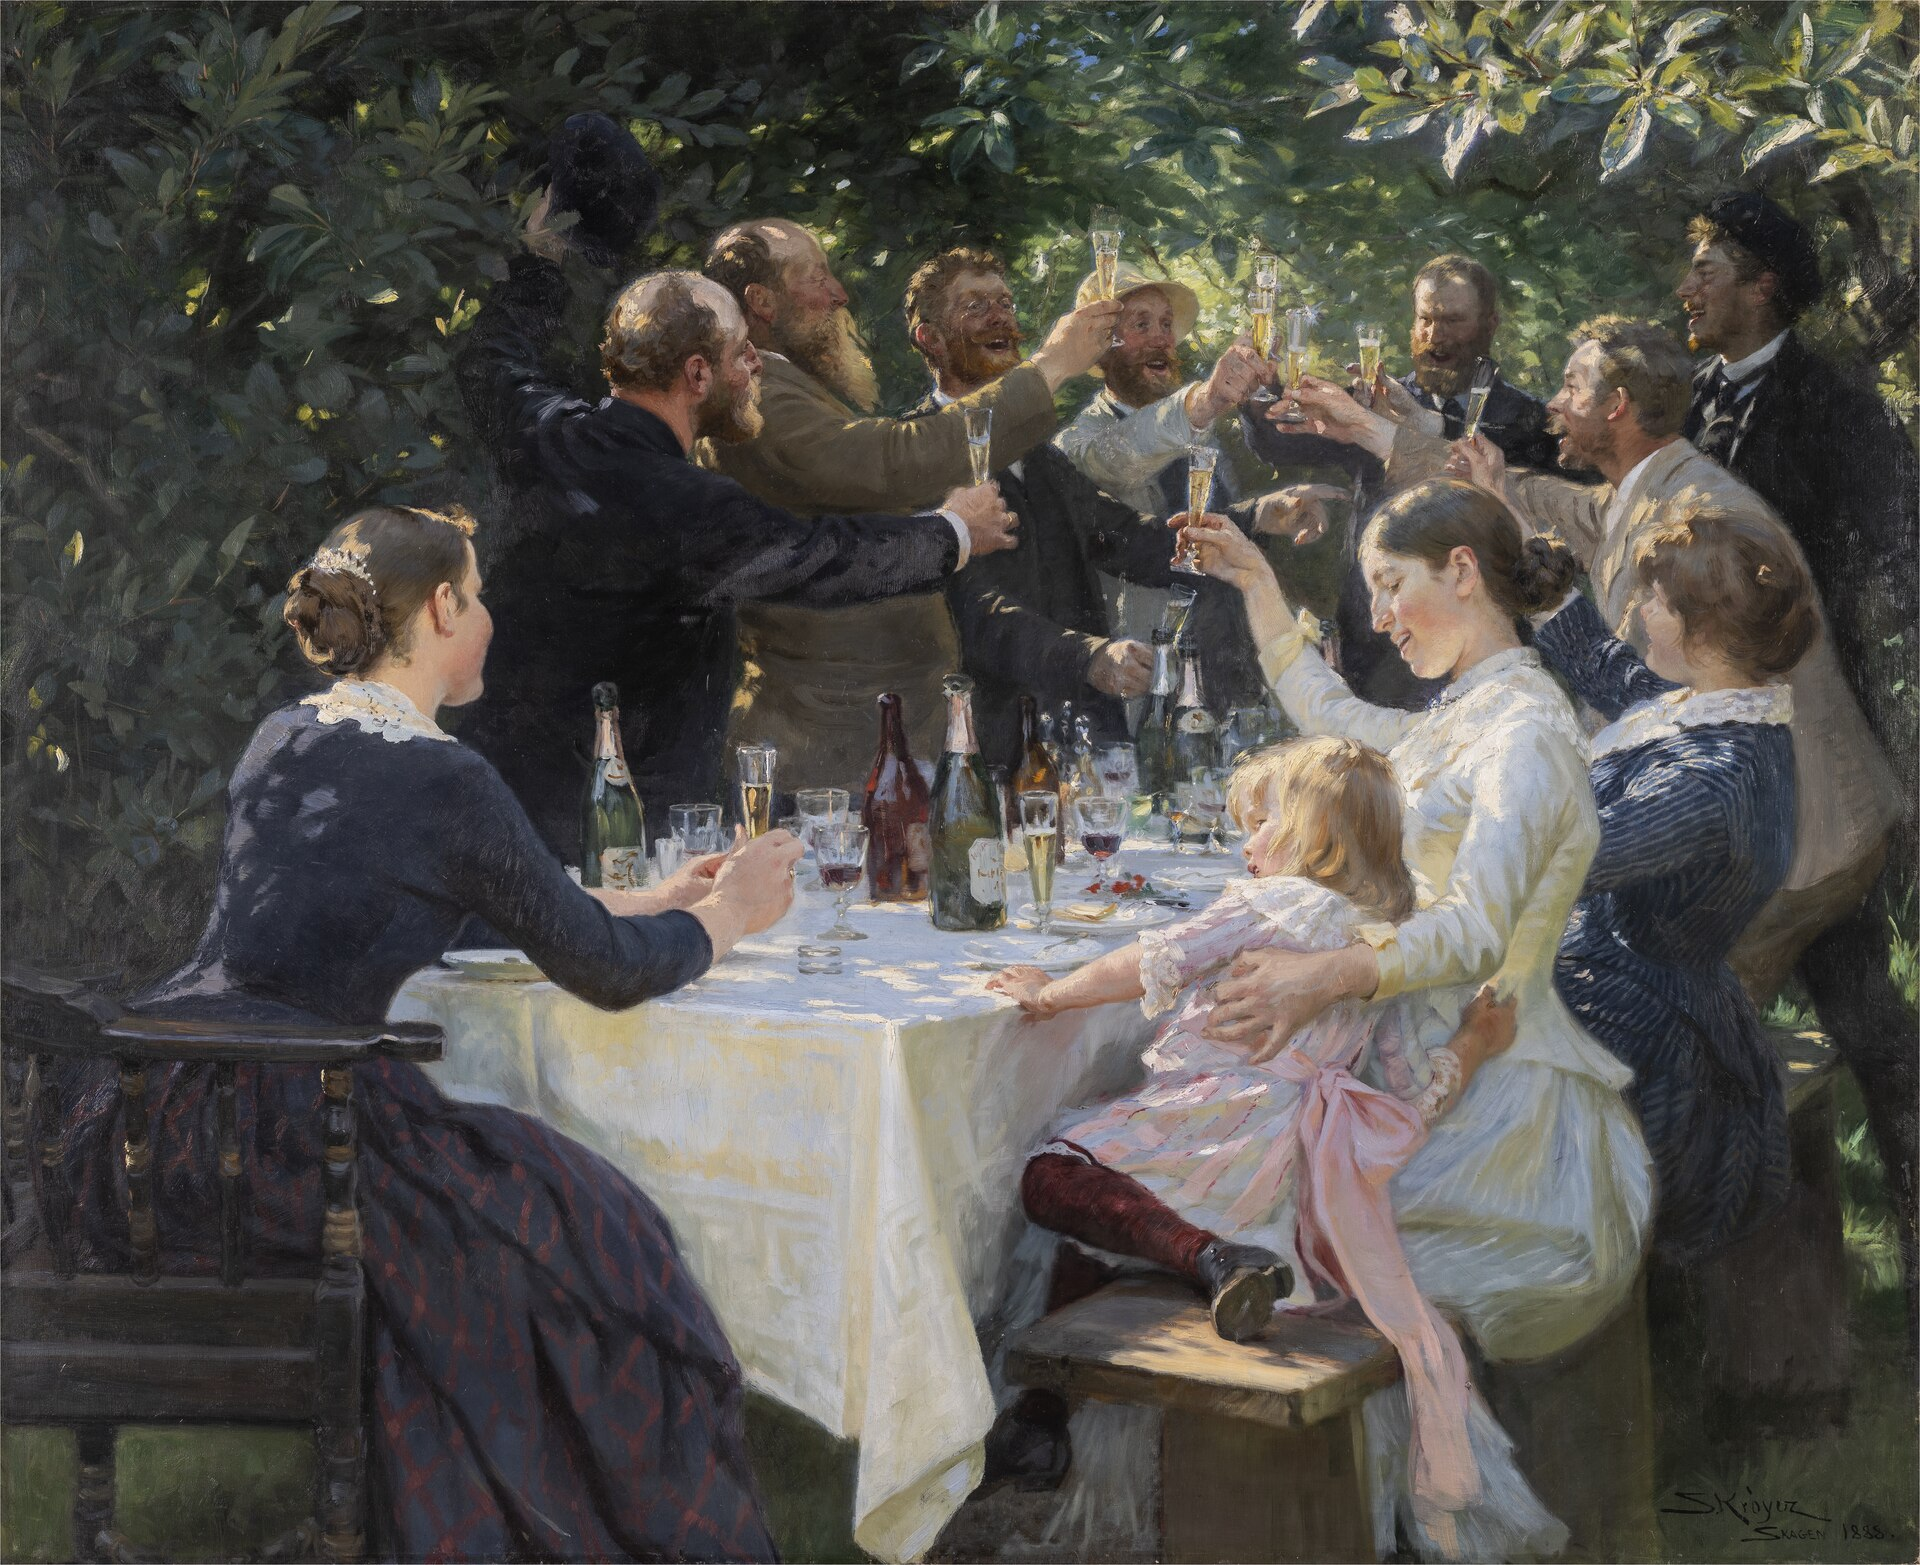

In [ ]:
party_photo = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Hip%2C_Hip%2C_Hurrah%21_Artists%E2%80%99_Party%2C_Skagen_%28Peder_Severin_Kr%C3%B8yer%29_-_Gothenburg_Museum_of_Art_-_F_62.tif/lossy-page1-1920px-Hip%2C_Hip%2C_Hurrah%21_Artists%E2%80%99_Party%2C_Skagen_%28Peder_Severin_Kr%C3%B8yer%29_-_Gothenburg_Museum_of_Art_-_F_62.tif.jpg"
Image(party_photo, width=400)

In [ ]:
print(is_my_photo_fun(fetch_image_as_base64(party_photo)))

[[FUN]]
This photo is fun because:
- The background is not plain and light-colored, it is a natural setting with trees and foliage.
- The lighting is not even; there are shadows and reflections present.
- The people are not standing in a right position; they are seated around a table.
- The expressions are not plain; they are joyful and animated.
- Some individuals are wearing headwear.
- Not all eyes are fully visible due to the angle and movement.


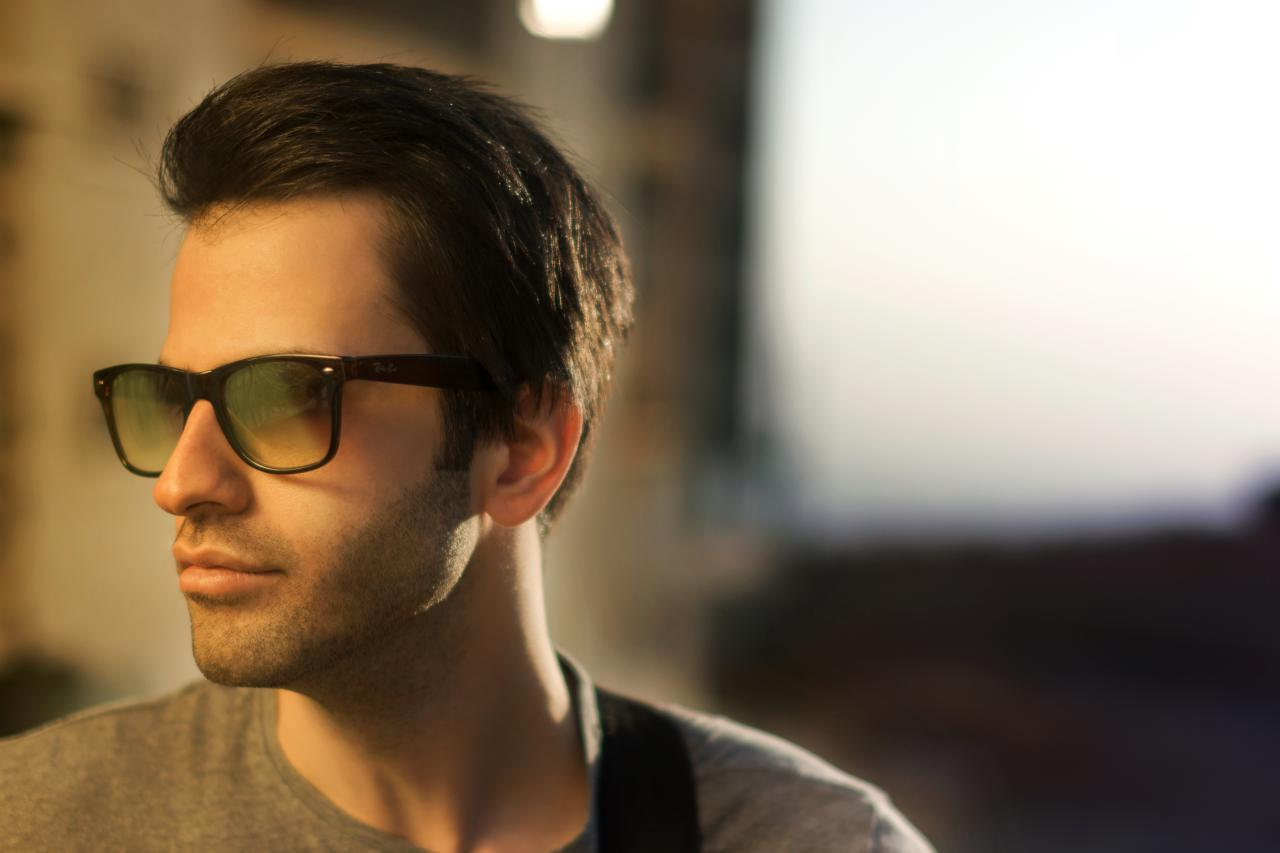

In [ ]:
professional_portrait_url = "https://upload.wikimedia.org/wikipedia/commons/b/bd/Portrait_of_a_handsome_man_with_bokeh_and_shallow_depth_of_field.jpg"
Image(professional_portrait_url, width=400)

In [ ]:
print(is_my_photo_fun(fetch_image_as_base64(professional_portrait_url)))

[[FUN]]

- The background is not plain or light-coloured.
- The lighting appears uneven, with shadows and reflections visible.
- The person is not standing in a direct position facing the camera.
- The person has an expression that is not plain and is not facing the camera in full view.
- The person is wearing sunglasses, which is a form of headwear.
- The eyes are not fully visible due to the sunglasses.


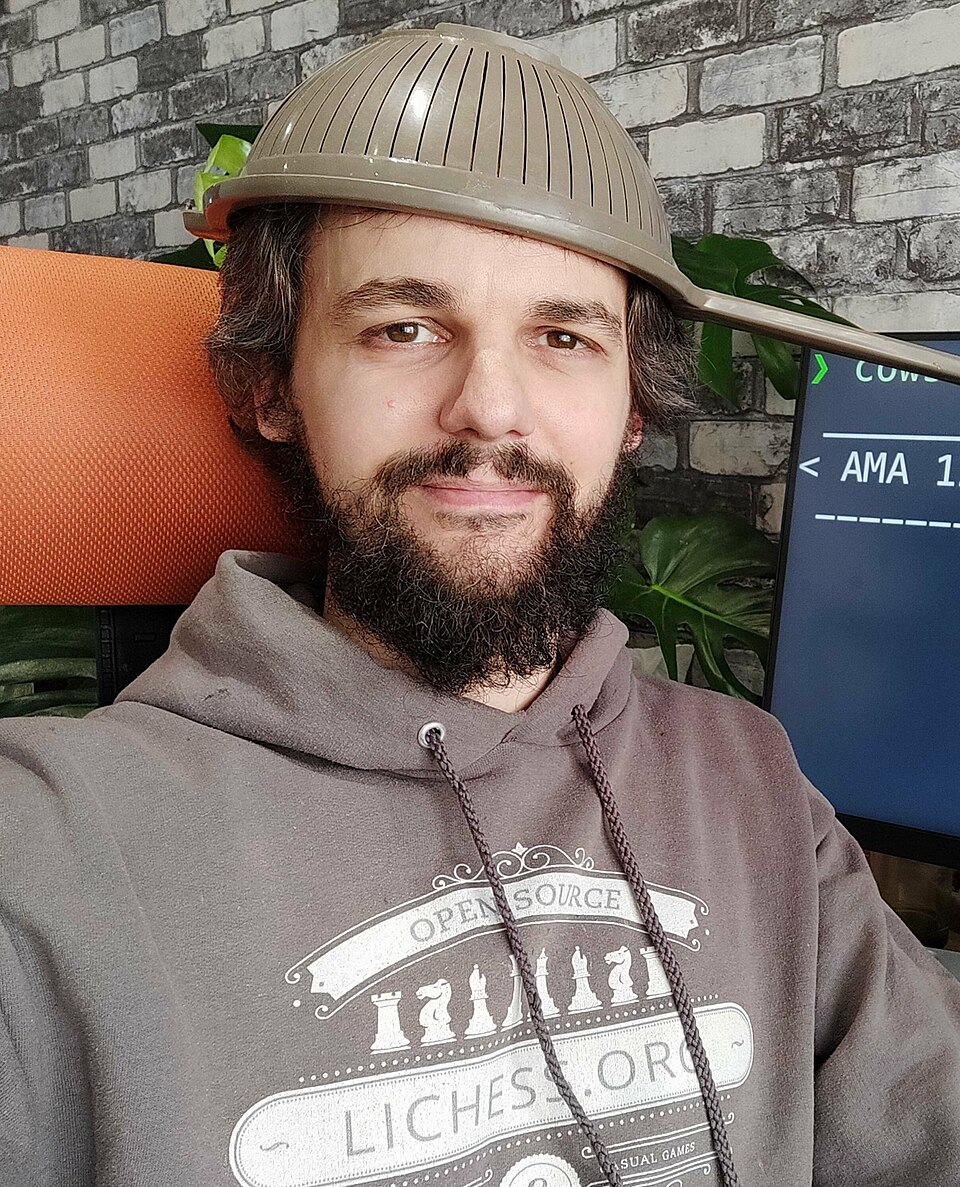

In [ ]:
pastafarian_photo_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Thibault_Duplessis_%28cropped%29.jpg/960px-Thibault_Duplessis_%28cropped%29.jpg"
Image(pastafarian_photo_url, width=400)

In [ ]:
print(is_my_photo_fun(fetch_image_as_base64(pastafarian_photo_url)))

[[FUN]]
This photo is fun because:
- Wears headwear (a colander)
- Has a plain expression but in a playful context (wearing a colander)
- Does not use a plain light-colored background (bricked wall and plants)
- Does not use even lighting with no shadows or reflections (light source creates shadows and reflections)
